# Linear models

## Index
1. [Import data](#import_data)
2. [Linear regression](#linear_regression)
    1. [Least squares](#least_squares)
    2. [Gradient descent](#gradient_descent)

## Import data <a id="import_data" />

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
import matplotlib.pyplot as plt


In [2]:
def get_data():
    curr_dir = os.getcwd()
    data_path = os.path.join(curr_dir, "./datasets/Advertising.csv")
    advert_data = pd.read_csv(data_path)
    advert_data.head()
    y = advert_data.loc[:,'sales']
    X = advert_data.loc[:,['TV', 'radio', 'newspaper']]
    return X, y

In [3]:
def get_train_test_data(X, y):
    X.insert(loc=0, column='intercept', value=pd.Series(1, index=X.index))
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, shuffle = True,          random_state = 42)
    return X_train, X_test, y_train, y_test

## Linear regression <a id="linear_regression" />



### Least squares <a id="least_squares" />

Find the regressors by using method of least squares. <br/>
$ \hat{y} = A^Tx, \qquad \hat{y} \in R, A \in R ^{k \times 1}, x \in R ^{k \times 1} $ <br/>
$ \text{MSE} = \sum \limits_{i=0}^n(y_i - \hat{y}_i)^2 $ <br/> 
$ \text{To minimize MSE}, \quad  \frac{\partial{MSE}}{\partial{A}} = 0 $ <br/>
$ \implies A = (X^TX)^{-1}(X^TY)$

In [4]:
X, y = get_data()
X_train, X_test, y_train, y_test = get_train_test_data(X, y)

In [5]:
# method of least-square
def least_square(X_train, y_train):
    pos_semi = X_train.T.dot(X_train)
    A = pd.DataFrame(np.linalg.pinv(pos_semi), 
    pos_semi.index, pos_semi.columns).dot(X_train.T.dot(y_train))
    return A

In [6]:
def get_mse(X, y, A):
    return y.subtract(X.dot(A)).pow(2).mean()

In [7]:
# Get regressors
A = least_square(X_train, y_train)
# MSE-train
mse_train = get_mse(X_train, y_train, A)
# MSE-test
mse_test = get_mse(X_test, y_test, A)
print(A)
print(mse_train, mse_test)

intercept    2.979067
TV           0.044730
radio        0.189195
newspaper    0.002761
dtype: float64
2.7051294230814134 3.174097353976193


In [8]:
X, y = get_data()

In [9]:
# normalize values
def normalize(val,min_val,max_val):
    if(min_val < max_val):
        return (val-min_val)/(max_val-min_val)
    return val
def normalize_feature(feature_series):
    min_val = feature_series.min()
    max_val = feature_series.max()
    return feature_series.apply(normalize, args=(min_val, max_val))

X_normalised = X.apply(normalize_feature, axis=0)

In [10]:
X_train, X_test, y_train, y_test = get_train_test_data(X_normalised, y)

In [11]:
# Get regressors
A = least_square(X_train, y_train)
# MSE-train
mse_train = get_mse(X_train, y_train, A)
# MSE-test
mse_test = get_mse(X_test, y_test, A)
print(A)
print(mse_train, mse_test)

intercept     3.011206
TV           13.226518
radio         9.384075
newspaper     0.313939
dtype: float64
2.7051294230814147 3.174097353976096


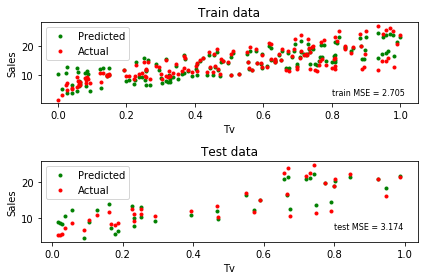

In [12]:
# plot least squares
# train data
plt.subplot(2,1,1)
plt.plot(X_train.TV, X_train.dot(A), 'g.')
plt.plot(X_train.TV, y_train, 'r.')

plt.legend(['Predicted', 'Actual'])
plt.xlabel('Tv')
plt.ylabel('Sales')
plt.title('Train data')
plt.text(0.8, 3, 'train MSE = {0}'.format(round(mse_train,3)), fontsize=8)
#plt.text("train MSE = {0} \n test MSE = {1}".format(mse_train, mse_test))
# test data
plt.subplot(2,1,2)
plt.plot(X_test.TV, X_test.dot(A), 'g.')
plt.plot(X_test.TV, y_test, 'r.')
plt.legend(['Predicted', 'Actual'])
plt.title('Test data')
plt.xlabel('Tv')
plt.ylabel('Sales')
plt.text(0.8, 7, 'test MSE = {0}'.format(round(mse_test,3)), fontsize=8)
plt.tight_layout()
#axs[1].title('Test data')
#.title('MSE vs TV for test and train data')
#plt.title('MSE vs TV for test and train data')

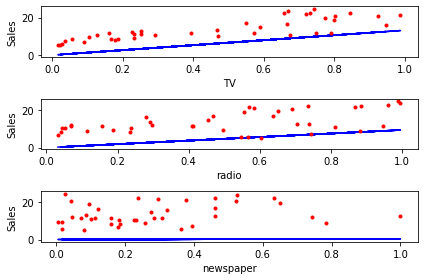

In [13]:
X, y = get_data()
X_normalised = X.apply(normalize_feature, axis=0)
X_train, X_test, y_train, y_test = get_train_test_data(X_normalised, y)
A = least_square(X_train, y_train)
cols = np.array(X_train.columns.drop('intercept'))
fig, axs = plt.subplots(len(cols))
for i,col in enumerate(cols):
    A_col = A[col]
    axs[i].plot(X_test[col], X_test[col].multiply(A_col), 'b')
    axs[i].plot(X_test[col], y_test, 'r.')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Sales')
    #fig.text(0.5,i + 3, '{0}'.format(col, fontsize=8))
plt.tight_layout()

In [14]:
# for comparison
A_linear = A
mse_linear = mse_test

### Gradient Descent <a id="gradient_descent" />

1. Initialize regressors A
2. In each iteration move along the gradient of the mse: <br />
$ 
\text{MSE } J(A) = \sum \limits_{i=0}^n(y_i - \hat{y}_i)^2 \\
A_1 = [0]_{k \times 1} \\
A_{i+1} = A_{i} - \alpha\frac{\partial J(A)}{\partial A} \quad \text{where  } i \in N, i \lt max\_iter $
3. Breaking condition: <br />
$
\mid J(A_{j}) - J(A_i) \mid \lt thres, \quad \text{where  } j-i \gt seed
$

In [15]:
X, y = get_data()
X_normalised = X.apply(normalize_feature, axis=0)
X_train, X_test, y_train, y_test = get_train_test_data(X_normalised, y)

In [22]:
# find regressors

# initialize regressors
sigma = 1
mu = 0
A = pd.Series(sigma*np.random.randn(len(X_normalised.columns)) + mu, index=X_normalised.columns)
A_curr = A
A_init = A
mse_init = get_mse(X_train, y_train, A_init)

max_iter = pow(10, 4) # max num of iterations
thres = pow(10, 1) # min delta of mse_prev & mse_curr
mse = mse_init # some max error value for intialization
learn_rate = pow(10, -1) # learning rate
seed = 15 # if delta less than threshold for seed number of times
seed_count = 0

#for plot
A_plot = []
mse_plot = []

# gradient descent logic
for i in range(max_iter):
    delta = (y_train.subtract(X_train.dot(A_curr))).T.dot(X_train).multiply(learn_rate)
    A_curr = A_curr.subtract(delta)
    mse_curr = get_mse(X_train, y_train, A_curr)
    A_plot.append(A_curr)
    mse_plot.append(mse_curr)
    if(abs(mse_curr-mse) < thres):
        seed_count = seed_count + 1
    else:
        seed_count = 0
    if(mse > mse_curr):
        mse = mse_curr
        A = A_curr
    if(seed_count == seed):
        break
print('no. of iterations: ', i)
print('mse for gradient descent at initialization: ', mse_init)
print('mse for gradient descent: ', get_mse(X_test, y_test, A))
print('mse for least squares: ', mse_linear)
pd.DataFrame({'Least squares': A_linear, 'Initial params': A_init, 'Gradient descent': A}, index=A.index)

no. of iterations:  9999
mse for gradient descent at initialization:  205.62305562649186
mse for gradient descent:  198.61082150213812
mse for least squares:  3.174097353976096


,Least squares,Initial params,Gradient descent
intercept,3.011206,-0.518621,-0.518621
TV,13.226518,0.159230,0.159230
radio,9.384075,1.741962,1.741962
newspaper,0.313939,0.772222,0.772222


In [247]:
A_curr = pd.Series(sigma*np.random.randn(len(X_normalised.columns)) + mu, index=X_normalised.columns)
(y_train.subtract(X_train.dot(A_curr))).T.dot(X_train).multiply(learn_rate)

intercept    203.925424
TV           121.726267
radio        109.534807
newspaper     56.185130
dtype: float64

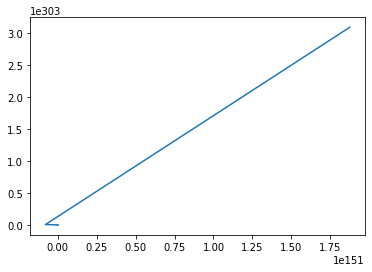

In [248]:
x_axis = pd.DataFrame(A_plot).dropna()['TV']
y_axis = mse_plot[:x_axis.size]
plt.plot(x_axis, y_axis)

In [ ]:
# plot cost function vs each feature

In [ ]:
#plot cost 

In [7]:
'''
split into training test
1) add one column
2) initialize x
3) compute derivative
4) set threshold
5) cutoff
'''

200